# 使用 Relax 训练 API 训练模型

社区对使用 TVM 进行模型训练的关注日益增加。作为 TVM 的新一代图级中间表示（IR），Relax 也需要满足训练模型的需求。

在 Relax 上构建了完整的训练工作流，包含：
- **基于源码转换的自动微分工具**
- **优化器抽象** 及常见优化器实现
- **损失函数抽象** 及常见损失函数
- 将这些组件整合的易用 **训练器 API**

这些训练 API 可满足多种需求：
- 从零开始训练模型：利用 TVM 的编译优势加速训练过程
- 基于 TVM 在设备端进行模型微调
- 将训练过程部署到 TVM 支持的各种设备（如 FPGA 和树莓派）

本教程将演示如何通过训练 API：
1. 使用高层 Trainer API 从头训练模型
2. 使用底层自动微分、优化器和损失函数 API 进行训练
3. 深入解析自动微分系统的源码实现

将使用 Fashion MNIST 数据集训练 MLP 模型，该方法同样适用于大多数常见模型。

## 准备工作

首先，需要导入必要的依赖项并加载数据集。

In [1]:
import numpy as np
import tvm
from tvm.relax.training.loss import CrossEntropyLoss
from tvm.relax.training.setup_trainer import SetupTrainer
from tvm.relax.training.trainer import Trainer
from tvm import relax
from tvm.script import ir as I, relax as R
from tvm.relax.transform import LegalizeOps
from tvm.relax.training.optimizer import SGD

batch_size = 64

将在 [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) 数据集上训练模型。以下代码使用 torchvision（PyTorch 的计算机视觉库）下载并预处理数据。

请注意，仅使用 PyTorch 进行数据加载。从 PyTorch Dataloader 加载的数据将在训练过程中转换为 NumPy 数组。

In [2]:
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as Tr
import torch.nn.functional as Func

train_data = torchvision.datasets.FashionMNIST(
    root=".temp",
    train=True,
    download=True,
    transform=Tr.Compose([Tr.ToTensor(), Tr.Lambda(torch.flatten)]),
    target_transform=lambda x:Func.one_hot(torch.tensor(x), 10).float()
)
test_data = torchvision.datasets.FashionMNIST(
    root=".temp",
    train=False,
    download=True,
    transform=Tr.Compose([Tr.ToTensor(), Tr.Lambda(torch.flatten)]),
    target_transform=lambda x:Func.one_hot(torch.tensor(x), 10).float()
)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

从数据加载器中取一个样本来看：Fashion MNIST 数据集中的每个样本都是 $28 \times 28$ 的灰度图像，并属于10种服装类别之一。

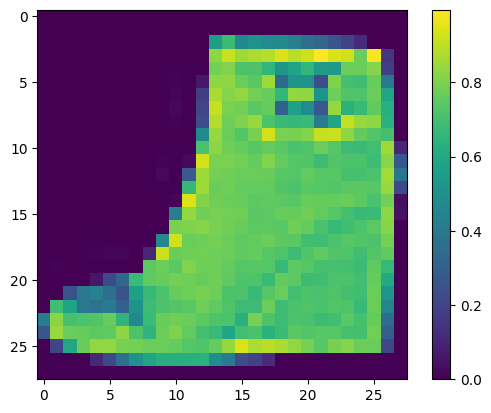

Class: Ankle boot


In [3]:
import matplotlib.pyplot as plt

img, label = next(iter(train_loader))
img = img[0].reshape(1, 28, 28).numpy()
plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()
print("Class:", class_names[label.argmax()])

## 模型定义

将使用三层感知机（Perceptron）进行图像分类。首先需要定义该感知机的主干结构：

In [4]:
@tvm.script.ir_module
class MLP:
    I.module_attrs({"param_num": 6, "state_num": 0})
    @R.function
    def backbone(
        x: R.Tensor((batch_size, 784), "float32"),
        w0: R.Tensor((784, 128), "float32"),
        b0: R.Tensor((128,), "float32"),
        w1: R.Tensor((128, 128), "float32"),
        b1: R.Tensor((128,), "float32"),
        w2: R.Tensor((128, 10), "float32"),
        b2: R.Tensor((10,), "float32"),
    ) -> R.Tensor((batch_size, 10), "float32"):
        with R.dataflow():
            lv0 = R.matmul(x, w0)
            lv1 = R.add(lv0, b0)
            lv2 = R.nn.relu(lv1)
            lv3 = R.matmul(lv2, w1)
            lv4 = R.add(lv3, b1)
            lv5 = R.nn.relu(lv4)
            lv6 = R.matmul(lv5, w2)
            out = R.add(lv6, b2)
            R.output(out)
        return out

## 方法一：使用训练器 API

### 训练器结构

训练给定模型的更简单方式是使用训练器 API。该 API 提供了参数更新和模型推理的核心接口。

构建训练器时，需要先创建优化器和损失函数。我们只需指定**超参数**（如学习率、归约方法等）即可完成构建，在此阶段无需提供模型参数。

In [5]:
loss = CrossEntropyLoss(reduction="sum")
opt = SGD(0.01, weight_decay=0.01)

随后，需要构建 `SetupTrainer`。这是 `Trainer` 的辅助类，本质上是变换（pass），用于将主干模块转换为完整且规范化的训练器模块。

变换后的模块将包含以下方法：
- `predict`: 模型预测方法（由输入模块提供）
- `loss`: 计算预测结果与真实标签之间的指定损失
- `loss_adjoint`: 计算损失值及参数的伴随梯度
- `update_params`: 接收参数、参数梯度和优化器状态作为输入，返回更新后的参数和新优化器状态。该方法包含名为 `optim_state` 的函数属性，表示指定优化器的初始状态。

构建 `SetupTrainer` 需要指定以下要素：
1. 损失函数
2. 优化器
3. 模型输出和标签的 `struct_info`（结构信息）

In [6]:
out_sinfo = relax.TensorStructInfo((batch_size, 10), "float32")
label_sinfo = relax.TensorStructInfo((batch_size, 10), "int64")

setup_trainer = SetupTrainer(loss, opt, [out_sinfo, label_sinfo])

最后一步，引入 `Trainer`。`Trainer` 是运行时组件，通过 SetupTrainer 配置主干模块结构后构建并运行模块，同时内部维护参数的运行时值。

构建 Trainer 需要指定以下要素：
1. 主干模块（Backbone）
2. 参数数量 $n$
3. `SetupTrainer` 实例

主干函数的前 $n$ 个参数将被识别为模型参数，这些参数将在训练过程中被优化器更新。

In [ ]:
target = "llvm"
dev = tvm.device(target, 0)
train_mod = setup_trainer(MLP)
ex = tvm.compile(train_mod, target)
vm = relax.VirtualMachine(ex, dev, profile=True)

In [ ]:
trainer = Trainer(Backbone, 6, setup_trainer)
# build the IRModule in the trainer
trainer.build(target="llvm", device=tvm.cpu(0))

### 训练流程

训练器构建完成后，即可在其基础上执行标准训练流程。我们将随机初始化参数，并进行 5 轮（epoch）训练。

`Trainer` 提供 `xaiver_uniform_init_params` 方法（注：应为 Xavier Uniform 初始化），用于通过 Xavier 均匀分布初始化所有参数。若需自定义参数初始化，可调用以下方法：
- `trainer.load_params(extern_param_dict: Dict[str, Union[np.ndarray, NDArray]])` 加载预设参数
- `trainer.export_params() -> Dict[str, NDArray]` 导出当前参数

`update_params` 方法将用于参数更新，其内部执行流程如下：
1. **前向传播**：获取模型输出及损失值
2. **梯度计算**：计算参数梯度
3. **参数更新**：根据优化器算法更新参数
4. **返回损失**：将当前损失值返回调用方

`predict` 方法专为推理设计，接收一批特征数据并返回预测结果（即主干网络的输出）。

In [ ]:
trainer.xaiver_uniform_init_params()


epochs = 5
log_interval = 200


for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        loss = trainer.update_params(data.numpy(), target.numpy())

        if batch_idx % log_interval == 0 or batch_idx == len(train_loader):
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.numpy():.2f}")

    total, correct = 0, 0
    for data, target in test_loader:
        predict = trainer.predict(data.numpy()) # batch_size * 10
        total += len(data)
        correct += np.sum(predict.numpy().argmax(1) == target.numpy().argmax(1))

    print(f"Train Epoch: {epoch} Accuracy on test dataset: {100.0 * correct / total:.2f}%")

### 为什么需要区分 Trainer 和 SetupTrainer？

这种设计源于「编译期」与「运行期」的职责分离：

1. **编译期组件**（SetupTrainer 及之前组件）：
   - 负责构建完整的计算图（IRModule）
   - 完成所有静态分析与优化
   - 生成可部署的通用计算逻辑

2. **运行期组件**（Trainer）：
   - 接收编译期生成的 IRModule
   - 管理模型参数的动态更新
   - 维护训练过程中的临时状态

这种分离架构使 TVM 能够：
- 在服务器端完成计算图编译优化
- 将优化后的 IRModule 部署到边缘设备
- 在资源受限的设备上仅执行必要的参数更新

这正是 TVM 实现「一次编译，到处运行」的关键设计决策。

## 方法二：使用底层训练 API

我们也可以通过底层训练 API 直接构建和运行 IRModule。这些 API 主要包括：
- 损失函数库
- 优化器库
- 自动微分过程

### 损失函数

TVM 在 `tvm.relax.training.loss` 模块中提供了丰富的损失函数实现，包括：
- `CrossEntropyLoss`（交叉熵损失）
- `L1Loss`（L1 损失）
- `MSELoss`（均方误差损失）等

您也可以通过继承 `tvm.relax.training.loss.Loss` 基类来自定义损失函数。

损失类的实例化仅需指定超参数，其 `__call__()` 方法将接收模型输出和标签的 struct_info（结构信息），并生成对应的 Relax 损失函数：

In [ ]:
func = CrossEntropyLoss(reduction="sum")(out_sinfo, label_sinfo)
print(func)

基于自动微分过程的技术要求，我们需要将主干函数与损失函数进行融合。为此，我们提供了 `relax.training.utils.append_loss` 工具来实现二者的融合：

In [ ]:
Backbone["loss"] = relax.training.utils.append_loss(Backbone["predict"], func)
Backbone.show()

### 梯度计算过程

为优化模型参数，我们需要计算参数的梯度。TVM 提供了自动微分转换过程 `relax.transform.Gradient` 来实现梯度计算。

该自动微分（AD）系统是训练工作流的核心，基于源码转换方法实现。当前版本对输入函数有以下限制：
1. **单数据流块限制**：函数必须仅包含一个数据流块
2. **算子支持限制**：仅支持算术运算、元组操作等基础 Relax 算子

`Gradient` 接收三个关键参数：
- 目标函数的全局变量名
- 需要计算梯度的参数变量
- 输入 IRModule

执行后将返回包含梯度计算逻辑的新 IRModule。

In [ ]:
params = Backbone["loss"].params[:6]

Backbone = relax.transform.Gradient(
    Backbone.get_global_var("loss"),
    require_grads=params
)(Backbone)
Backbone.show()

### 优化器

TVM 在 `relax.training.optimizer` 模块中提供了多种经典优化器实现，包括：
- 基础 SGD
- 带动量的 SGD
- Adam 优化器

您也可以通过继承 `relax.training.optimizer.Optimizer` 基类来实现自定义优化器。

优化器实例的创建仅需指定超参数（如学习率）。通过 `init()` 方法进行初始化时需传入：
- 单个 Relax 变量 或
- Relax 变量列表（计算图中的变量节点）

该方法将完成优化器状态的初始化。初始化后，可通过以下两种方式使用优化器：
1. 调用 `get_function()` 获取对应的 Relax 优化函数
2. 将其关联到现有 IRModule 的计算流程中

In [ ]:
opt = relax.optimizer.SGD(0.1).init(params)
Backbone["SGD"] = opt.get_function()
print(Backbone["SGD"])

### 训练流程

完成 IRModule 的构建后，即可开始模型训练。我们需要依次执行以下操作：
1. 对 IRModule 进行规范化处理
2. 编译生成可执行模块
3. 准备必要的输入数据：

In [ ]:
# Build and legalize module
lowered_mod = LegalizeOps()(Backbone)
ex = relax.vm.build(lowered_mod, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())


def _get_shape_as_int_list(var):
    return [int(val) for val in var.struct_info.shape]

params_list = [tvm.nd.array(np.ones(_get_shape_as_int_list(i), "float32")) for i in params]
param_input_tuple = tuple_object(params_list)

x_input, y_input = next(iter(train_loader))
x_input = tvm.nd.array(x_input)
y_input = tvm.nd.array(y_input)

# The input should be (*param_input_tuple, x_input, y_input)
# At the runtime of TVM, arguments should be TVM NDArray or TVM runtime ADT objects.

本演示仅展示单步训练过程，多步训练逻辑与此类似。

**核心组件交互流程**：
1. **伴随函数**（由自动微分过程生成）：
   - 输入：主干网络输入 + 真实标签
   - 输出：损失值 + 参数梯度元组

2. **优化器函数**（由优化器类构建）：
   - 输入：参数元组 + 梯度元组 + 优化器状态元组
   - 输出：更新后的参数元组 + 新优化器状态元组

通过 `opt.state` 可获取优化器状态对象，该状态包含优化过程中的关键信息：
- 已执行的训练步数（steps）
- 动量缓存（momentum）
- 自适应学习率参数（如 Adam 中的一/二阶矩估计）

In [ ]:
# forward and find the gradient
loss, param_grad_tuple = vm["loss_adjoint"](*param_input_tuple, x_input, y_input)
# update parameters
param_input_tuple, opt.state = vm["SGD"](param_input_tuple, param_grad_tuple, opt.state)

打印计算结果：

In [ ]:
print(loss.numpy)
print(len(param_input_tuple), len(param_grad_tuple))
print(param_input_tuple[0])
print(param_grad_tuple[0])